In [1]:
# in the name of god 

In [18]:
import pandas as pd 
import numpy as np
from IPython.display import clear_output
import time
import pickle
from matplotlib.cbook import flatten
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 5)})

In [3]:
#prepare Dataset gyroscope
dfg=pd.read_csv('16\giroscopio_terra.csv')
dfg['ts']=pd.to_datetime(dfg.apply(lambda x:(round((x.uptimeNanos-dfg.uptimeNanos[0])/1000000)*1000000),axis=1))
dm=dfg['ts']
dfg=dfg.drop('uptimeNanos',1).drop('timestamp',1)
dfg=dfg.set_index('ts').rename(columns={'x': 'g-x','y': 'g-y','z': 'g-z'})
dfg.head(3)

,g-x,g-y,g-z
ts,,,
1970-01-01 00:00:00.000,-0.070372,0.000844,0.029619
1970-01-01 00:00:00.010,-0.058695,0.009130,0.024406
1970-01-01 00:00:00.032,0.006625,-0.002283,-0.015018


In [4]:
#prepare Dataset accelarator
dfa=pd.read_csv('16\\acelerometro_terra.csv')
dfa['ts']=dm
dfa=dfa.drop('uptimeNanos',1).drop('timestamp',1)
dfa=dfa.set_index('ts').rename(columns={'x': 'a-x','y': 'a-y','z': 'a-z'})
dfa.head(3)

,a-x,a-y,a-z
ts,,,
1970-01-01 00:00:00.000,-0.161602,0.120174,9.596758
1970-01-01 00:00:00.010,-0.122628,0.315638,9.425655
1970-01-01 00:00:00.032,-0.178777,0.330180,9.445955


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D31835DF88>,
      dtype=object)

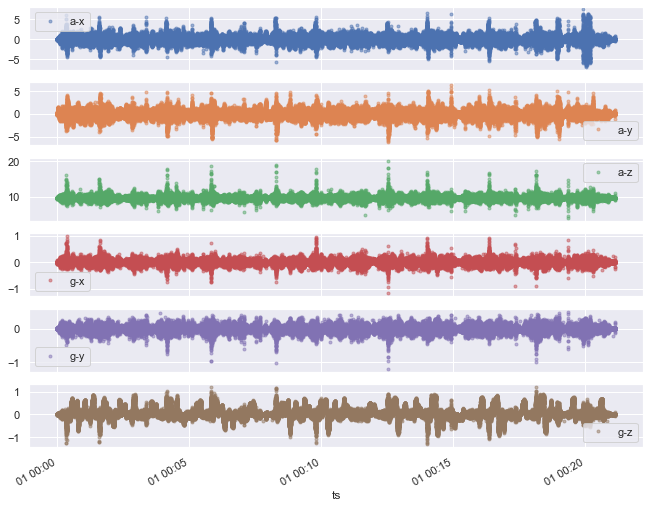

In [5]:
df = pd.concat([dfa, dfg], axis=1, join='outer')
df.plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)

In [6]:
#prepare Labeled dataset
dfl=pd.read_csv('16\\groundTruth.csv')
dfl['length']=dfl.en-dfl.st
lmean=dfl.length.mean()
lstd=dfl.length.std()

#extract the labels for clutering precision its for after clustering
def time_convertor(x):
    s,h,m=0,0,0
    s=round(x%60,2)
    m=int(x/60)
    h=int(m/60)
    m=m%60
    time=str(h)+':'+str(m)+':'+str(s)
    return pd.to_datetime('1970-01-01 '+time)

dfl['st_time']=dfl.apply(lambda x:time_convertor(x.st) ,axis=1 )
dfl['en_time']=dfl.apply(lambda x:time_convertor(x.en) ,axis=1 )
dfl=dfl.drop('st',1).drop('en',1).drop('length',1)
evented_label=list()
for i in range(len(dfl)):
    evented_label.append((dfl.iloc[i][0],dfl.iloc[i][1],dfl.iloc[i][2]))

In [7]:
#Dont RUN this part
#we should optimize M
#lengh of random event
from random import gauss
L=round(gauss(lmean,lstd)*50)
M=round(gauss(0.5,0.5)*50)

temp_event=list()
pointer=0
stop=False
#go on timeserise for event extraction
while stop!=True:
    clear_output(wait=True)
    M=round(gauss(1,0.5)*50)
    pointer=pointer + M
    #go forward till reach M
    L=round(gauss(lmean,lstd)*50)
    l_min=pointer-int(L/2)
    l_max=pointer+int(L/2)
    if (l_min<0):
        l_min=0
    if (l_max>len(df)):
        l_max=len(df)
        stop=True

    print('extraction ',l_max/len(df),' %  is complete')
    
    temp_event.append(df[l_min:l_max])


extraction  1.0  %  is complete


In [8]:
#Dont RUN this part
#calculate distance
from fastdtw import fastdtw
distance=list()
n=0
k=(len(temp_event))
k=k*k
t1=time.time()
for i,x in enumerate(temp_event):
    dumy=list()
    for j,y in enumerate(temp_event):
        clear_output(wait=True)
        n=n+1
        print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
        if (i<=j):
            continue
        else:
            dist,_=fastdtw(x,y)
            dumy.append(dist)
        
    distance.append(dumy)
t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton distant')


disstance calculatoin  100.0  %  is complete
1294 min has time for calculaton distant


In [9]:
#Dont RUN this part
#clustering precision
n=0
k=len(temp_event)*len(evented_label)
labels_distance=list()

for tag,st,en in evented_label:
    dummy=list()
    for t_e in temp_event:
        clear_output(wait=True)
        n=n+1
        print('disstance calculatoin ',round((n/k)*100,2),' %  is complete')
        dist,_=fastdtw(df[st:en],t_e)
        dummy.append(dist)
    labels_distance.append((tag,dummy))


disstance calculatoin  100.0  %  is complete


In [11]:
#Save temp_event
with open("temp_event_on20.txt", "wb") as fp:
    pickle.dump(temp_event, fp)
    
#Save distance matrix
with open("distance_on20.txt", "wb") as fp:
    pickle.dump(distance, fp)
    
#Save labeds distance matrix
with open("labels_distance_on20.txt", "wb") as fp:
    pickle.dump(labels_distance, fp)
    

In [12]:
#load File , save the time of calculation
with open("temp_event_on20.txt", "rb") as fp:
    te = pickle.load(fp)
with open("distance_on20.txt", "rb") as fp:
    dc = pickle.load(fp)
with open("labels_distance_on20.txt", "rb") as fp:
    ld = pickle.load(fp)

In [13]:
#make it as matrix 
#full it with zero for squaring
from copy import deepcopy
def creat_Symmetric_matrix(file):  
    MTX=deepcopy(file)
    for i in range(len(MTX)):
        while len(MTX[i])!=len(MTX):
            MTX[i].append(0)
    #make it Symmetry from diameter
    arr=np.array(MTX)
    dis=np.array(MTX)
    for i in range(len(arr)):
        for j in range(len(arr)):
            if (i>j):
                dis[j][i]=arr[i][j]
    return dis
dis=creat_Symmetric_matrix(dc)

No handles with labels found to put in legend.


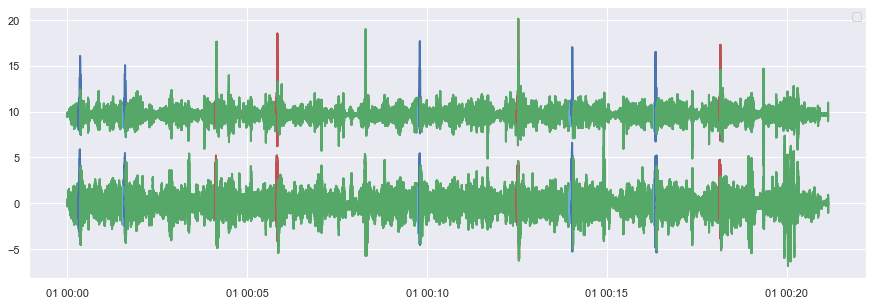

In [14]:
#initial clustering
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage = 'average').fit(dis)

plot_list=list()
for i,el in enumerate(te):
    plot_list.append((el,cluster.labels_[i]))
    
fig, ax = plt.subplots()

for el in plot_list:
    if el[1]==0:
        ax.plot(el[0], linestyle='-', linewidth=2,c='g')
    elif el[1]==1:
        ax.plot(el[0], linestyle='-', linewidth=2,c='b')
    elif el[1]==2:
        ax.plot(el[0], linestyle='-', linewidth=2,c='r')
    elif el[1]==3:
        ax.plot(el[0], linestyle='-', linewidth=2,c='c')
    elif el[1]==4:
        ax.plot(el[0], linestyle='-', linewidth=2,c='m')
    elif el[1]==5:
        ax.plot(el[0], linestyle='-', linewidth=2,c='y')
    elif el[1]==6:
        ax.plot(el[0], linestyle='-', linewidth=2,c='k')
    elif el[1]==7:
        ax.plot(el[0], linestyle='-', linewidth=2,c='b')
    elif el[1]==8:
        ax.plot(el[0], linestyle='-', linewidth=2,c='r')
    elif el[1]==9:
        ax.plot(el[0], linestyle='-', linewidth=2,c='w')

ax.legend();
plt.show()

In [15]:
#calculate the precision of clustering by labeled data 
exploratory_analysis=list()
for el in ld:
    midle_list=list()
    label_tag =el[0]
    label_distance=el[1].copy()
    label_distance.append(0)
    distance_matrix=dc.copy()
    distance_matrix.append(label_distance)
    DMX=creat_Symmetric_matrix(distance_matrix)
    Labels = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage = 'average').fit(DMX).labels_
    
    #extract lable  and labele it from the item we put at the end
    for i , x in enumerate(Labels):
        if i!=(len(Labels)-1):
            if x==Labels[-1]:
                midle_list.append(i)
    exploratory_analysis.append([label_tag,midle_list])


In [16]:
actg=dict()
for ev,x in exploratory_analysis:
    if ev in actg:
        actg[ev].append(x)
    else:
        actg.update({ev:[x]})

In [19]:
#calculate the Probibility of being event of temp_event
Prob_threshold=0.2
precision=list()

for event_name in actg:
    flat_list=list(dict.fromkeys(flatten(actg[event_name])))
    dprecision=list()
    for S in flat_list:
        x=0
        Number=len(actg[event_name])
        for i in range(Number):
            if S in actg[event_name][i]:
                x=x+1
        Probability=x/Number
        if Probability > Prob_threshold:
            dprecision.append((S,Probability))
    precision.append((event_name,dprecision))


as you can see its the Selected event and their Probability

In [26]:
precision[1]

('curva_direita_agressiva',
 [(19, 1.0),
  (20, 1.0),
  (21, 1.0),
  (100, 1.0),
  (621, 1.0),
  (622, 1.0),
  (891, 1.0),
  (1039, 1.0),
  (1040, 1.0),
  (1038, 0.4)])

as you can see its the Selected event and their Probability

In [27]:
precision[2]

('curva_esquerda_agressiva',
 [(251, 1.0),
  (252, 1.0),
  (253, 1.0),
  (361, 1.0),
  (362, 1.0),
  (1142, 1.0),
  (1143, 1.0),
  (781, 0.6),
  (782, 0.6),
  (783, 0.6)])

but in the others event we have nothing to say because its too much data and it seems somethings goes wrong

maybe if we increase Data , and done this algorithm again could be conclude something


In [29]:
precision[3]

('troca_faixa_direita_agressiva',
 [(1191, 0.3333333333333333),
  (1192, 0.3333333333333333),
  (1193, 0.3333333333333333),
  (1253, 0.3333333333333333),
  (1254, 0.6666666666666666),
  (0, 0.3333333333333333),
  (1, 0.3333333333333333),
  (2, 0.3333333333333333),
  (3, 0.3333333333333333),
  (4, 0.3333333333333333),
  (5, 0.3333333333333333),
  (6, 0.3333333333333333),
  (7, 0.3333333333333333),
  (8, 0.3333333333333333),
  (9, 0.3333333333333333),
  (10, 0.3333333333333333),
  (11, 0.3333333333333333),
  (12, 0.3333333333333333),
  (13, 0.3333333333333333),
  (14, 0.3333333333333333),
  (15, 0.3333333333333333),
  (16, 0.3333333333333333),
  (17, 0.3333333333333333),
  (18, 0.3333333333333333),
  (22, 0.3333333333333333),
  (23, 0.3333333333333333),
  (24, 0.3333333333333333),
  (25, 0.3333333333333333),
  (26, 0.3333333333333333),
  (27, 0.3333333333333333),
  (28, 0.3333333333333333),
  (29, 0.3333333333333333),
  (30, 0.3333333333333333),
  (31, 0.3333333333333333),
  (32, 0.33333